In [1]:
import pandas as pd
import importlib

In [2]:
import run_cmsopen
from pytorch_inferno.data import *

In [26]:
importlib.reload(run_cmsopen)

<module 'run_cmsopen' from '/home/centos/dev/pytorch_inferno/experiments/run_cmsopen.py'>

## Load data

In [27]:
#features = ['ht', 'aplanarity', 'sphericity', 'chargeEta', 'MET_met', 'deltaPhiTauMet', 'mt', 'mTauJet']
features = ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
shape_syst = ["jes"]
weight_syst = ["btag_weight1"]
use_weights = False

# Parameters for INFERNO training
inferno_args = {}
# Signal and bkg
inferno_args["b_true"] = 2800
inferno_args["mu_true"] = 400
# Number of shape nuisances
inferno_args["n_shape_alphas"] = len(shape_syst) + len(weight_syst)
# Constraints on the nuisance parameters - typically should be N(0,1) if +-1sigma templates are provided
inferno_args["shape_aux"] = None
# Uncertainties on signal norm - should be Normal(0,s) with s in absolute event numbers
inferno_args["s_norm_aux"] = None
# Boolean whether to let the background float
inferno_args["nonaux_b_norm"] = False

train_args = {}
train_args["lr"] = 1e-3
train_args["n_feats"] = 4
train_args["neurons"] = 100
train_args["bins"] = 10
train_args["temperature"] = 0.1
train_args["weights"] = False

In [28]:
OUTPATH = "/home/centos/data/inferno_cmsopen7"

bs = 1000
n_sig = 20000
epochs = 2
store = True


*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 2
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.001
n_feats 4
neurons 100
temperature 0.1
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=1819.374072265625 Valid=1431.3161073882004
2: Train=1374.4532373046875 Valid=1341.6915556808997


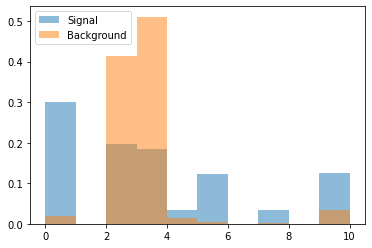

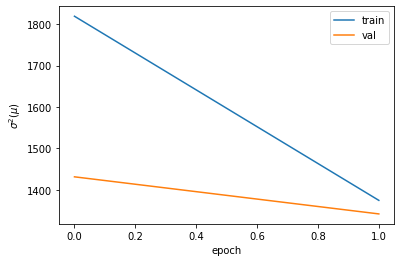

In [29]:
lt_inferno = run_cmsopen.train(OUTPATH, features = features, 
                                        shape_syst = shape_syst,
                                        weight_syst = weight_syst,
                                        epochs=epochs, bs=bs, n_sig=n_sig, 
                                        inferno_args = inferno_args, 
                                        train_args = train_args,
                                        use_weights = use_weights,
                                        store=store)

## Bayesian optimization

In [6]:
import pandas as pd
import numpy as np
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

In [17]:
def store_results(search_result, prior_names):

    params = pd.DataFrame(search_result['x_iters'])
    params.columns = [*prior_names]
    params = params.rename_axis('call').reset_index()
    scores = pd.DataFrame(search_result['func_vals'])
    scores.columns = ['score']
    result = pd.concat([params, scores], axis=1)
    result = result.sort_values(by=['score'])

    #result.to_hdf(self.path + 'skopt.h5', 'frame')

    return result 


def find_optimal_parameters( dimensions, initial_param, num_calls=12): 

    prior_values = []
    prior_names = []
    for var in dimensions:
        name = var.name
        print( name )
        prior_names.append(name)
        prior_values.append(initial_param[name])


    global num_skopt_call
    num_skopt_call = 0
    cv_results = []

    @use_named_args(dimensions)
    def fitness(**p): 

        global num_skopt_call

        print('\n \t ::: {} SKOPT CALL ::: \n'.format(num_skopt_call+1))
        print(p)

        train_args = {}
        train_args["lr"] = p["lr"]
        train_args["n_feats"] = 4
        train_args["neurons"] = p["neurons"]
        train_args["bins"] = 10
        train_args["temperature"] = p["temperature"]
        train_args["weights"] = False
        
        try:
            lt = run_cmsopen.train(OUTPATH, features = features, 
                                            shape_syst = shape_syst,
                                            weight_syst = weight_syst,
                                            epochs=epochs, bs=bs, n_sig=n_sig, 
                                            inferno_args = inferno_args, 
                                            train_args = train_args,
                                            use_weights = use_weights,
                                            store=store)
            score = min(lt.losses["val"])
        except:
            score = 10000

        
        num_skopt_call += 1

        return score

    search_result = gp_minimize( func = fitness, dimensions = dimensions,
                                 acq_func = 'EI', # Expected Improvement
                                 n_calls = num_calls, x0 = prior_values )

    #result = store_results(search_result, prior_names)

    return search_result, prior_names

In [18]:
skopt_dim_nominal = [
    Real(        low=1e-4, high=1e-2, prior='log-uniform', name='lr'),
    Real(        low=0.01, high=0.99, name='temperature'),
    Integer(     low=50, high=200,  name='neurons')
    ]
initial_param = {'lr': 1e-3, 'temperature':0.2, 'neurons' : 80}

lr
temperature
neurons

 	 ::: 1 SKOPT CALL ::: 

{'lr': 0.001, 'temperature': 0.2, 'neurons': 80}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.001
n_feats 4
neurons 80
temperature 0.2
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=2412.58837890625 Valid=1826.5885851629848
2: Train=1557.2384716796876 Valid=1528.356723127694
3: Train=1362.0093310546874 Valid=1442.004049366918
4: Train=1288.41845703125 Valid=1388.1896467537715
5: Train=1251.1458447265625 Valid=1343.2026093581628
6: Train=1211.3865283203124 Valid=1315.8908565126617
7: Train=1179.5335400390625 Valid=1282.5548243029364
8: Train=1159.9734375 Valid=1257.2410215180496
9: Train=1138.7088427734375 Valid=1258.7894918507543
10: Train=1129.0407739257812 Valid=1235.5556072366649
11: Train=1111.43646484375 Valid=1220.8700814082704
12: Train=1096.1781713867188 Valid=1213.5734421302532
13: Train=1088.5098950195313 Valid=1196.4349407327586
14: Train=1089.1327758789062 Valid=1208.4973523370152
15: Train=1065.3491235351562 Valid=1161.6332208041488
16: Train=1061.7445922851562 Valid=1172.572389799973
17: Train=1059.0033520507814 Valid=1156.184058879984
18: Train=1049.7410034179688 Valid=1135.2259921369882
19: Train=1036.1929858398437 Valid=1134.456174653152


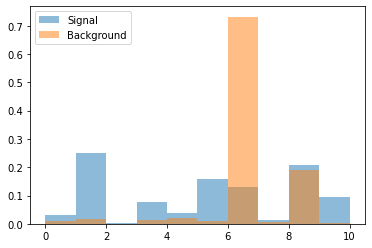

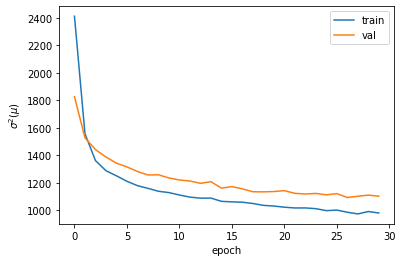


 	 ::: 2 SKOPT CALL ::: 

{'lr': 0.001305488406374723, 'temperature': 0.7622910683970598, 'neurons': 142}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.001305488406374723
n_feats 4
neurons 142
temperature 0.7622910683970598
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=2576.7556201171874 Valid=1897.0639480064656
2: Train=1647.657333984375 Valid=1604.3336770945582
3: Train=1441.8043798828126 Valid=1496.402310075431
4: Train=1369.0922265625 Valid=1422.5863415948277
5: Train=1307.975537109375 Valid=1376.4682785560344
6: Train=1271.672216796875 Valid=1340.7832389042296
7: Train=1242.7741186523438 Valid=1318.317277579472
8: Train=1209.5357958984375 Valid=1283.6174568965516
9: Train=1196.017529296875 Valid=1284.9333643419989
10: Train=1181.208857421875 Valid=1260.0895448882004
11: Train=1168.6366967773438 Valid=1261.186001481681
12: Train=1153.0209448242188 Valid=1236.5732506061422
13: Train=1135.8876782226562 Valid=1212.1201256061422
14: Train=1124.9505908203125 Valid=1197.5501582704742
15: Train=1120.7170825195312 Valid=1191.9150495858028
16: Train=1111.576083984375 Valid=1211.6710647056843
17: Train=1101.3893676757812 Valid=1177.1460360823007
18: Train=1085.68091796875 Valid=1181.3944218076508
19: Train=1085.7538256835937 Valid=1161.22645095299

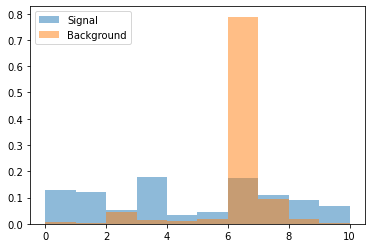

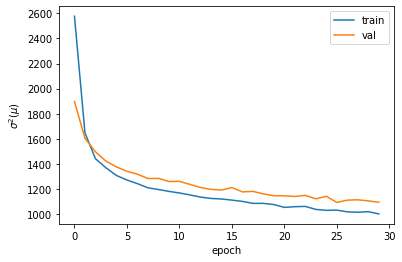


 	 ::: 3 SKOPT CALL ::: 

{'lr': 0.00012521169390572042, 'temperature': 0.2744659549012489, 'neurons': 179}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.00012521169390572042
n_feats 4
neurons 179
temperature 0.2744659549012489
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=2993.2512890625 Valid=2734.2725451239226
2: Train=2422.37208984375 Valid=2230.332696322737
3: Train=2007.727353515625 Valid=1986.0208319302262
4: Train=1796.8576611328126 Valid=1843.523715315194
5: Train=1692.096298828125 Valid=1746.3812887257543
6: Train=1630.8193212890626 Valid=1694.466552734375
7: Train=1575.5325634765625 Valid=1645.2610031654094
8: Train=1537.3083935546874 Valid=1610.036031788793
9: Train=1503.7049462890625 Valid=1572.9305125269398
10: Train=1459.658212890625 Valid=1539.018276872306
11: Train=1441.34685546875 Valid=1514.2460474474676
12: Train=1417.4670263671876 Valid=1489.3461072198277
13: Train=1401.935966796875 Valid=1470.7161444302262
14: Train=1378.7790283203126 Valid=1445.9633957435344
15: Train=1354.80359375 Valid=1431.120049838362
16: Train=1342.489345703125 Valid=1427.0441810344828
17: Train=1328.20109375 Valid=1402.0249781115301
18: Train=1307.8449853515624 Valid=1387.4712503367457
19: Train=1294.76044921875 Valid=1378.6206559806035
20: Train=128

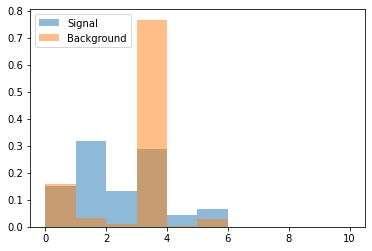

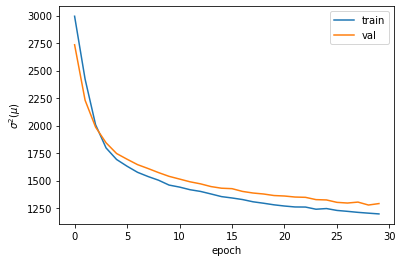


 	 ::: 4 SKOPT CALL ::: 

{'lr': 0.0029042674744225285, 'temperature': 0.6367496761999438, 'neurons': 143}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.0029042674744225285
n_feats 4
neurons 143
temperature 0.6367496761999438
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=2034.4869970703126 Valid=1558.8735562028555
2: Train=1422.223857421875 Valid=1377.6935950969828
3: Train=1297.6043017578124 Valid=1326.1102968413254
4: Train=1240.270146484375 Valid=1247.3336181640625
5: Train=1208.62337890625 Valid=1210.2614472487878
6: Train=1171.4273583984375 Valid=1199.9960200868804
7: Train=1154.8027905273439 Valid=1181.427629141972
8: Train=1136.4392260742188 Valid=1140.5124785324622
9: Train=1126.425078125 Valid=1146.3271021349676
10: Train=1120.993984375 Valid=1199.1051277949891
11: Train=1172.9466064453125 Valid=1161.1041196625808
12: Train=1115.8113110351562 Valid=1106.2033565126617
13: Train=1085.4327587890625 Valid=1112.6329619308997
14: Train=1057.6081518554688 Valid=1091.9693561422414
15: Train=1045.782744140625 Valid=1107.9685900457973
16: Train=1101.723076171875 Valid=1129.1740133351293
17: Train=1053.3953271484374 Valid=1080.803418389682
18: Train=1049.1024438476563 Valid=1088.0976688779633
19: Train=1093.5925952148436 Valid=1135.6353949185075

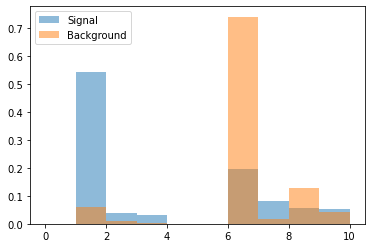

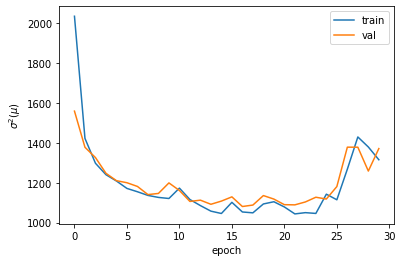


 	 ::: 5 SKOPT CALL ::: 

{'lr': 0.00033086849298300685, 'temperature': 0.6417367044652853, 'neurons': 172}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.00033086849298300685
n_feats 4
neurons 172
temperature 0.6417367044652853
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=3029.368212890625 Valid=2733.7622912176726
2: Train=2431.684814453125 Valid=2126.7387989964977
3: Train=2007.2053955078125 Valid=1859.2428694100215
4: Train=1786.2599609375 Valid=1684.057196255388
5: Train=1653.431064453125 Valid=1584.7998804552801
6: Train=1576.3157080078124 Valid=1516.5325254242996
7: Train=1507.4496875 Valid=1461.269253434806
8: Train=1437.5010498046875 Valid=1418.0799686826508
9: Train=1394.89609375 Valid=1386.5059351427801
10: Train=1363.08767578125 Valid=1363.8785063644934
11: Train=1324.5322705078124 Valid=1339.7980746565195
12: Train=1309.1946728515625 Valid=1319.0714195514547
13: Train=1301.3596435546874 Valid=1312.1799190126617
14: Train=1285.4036962890625 Valid=1294.7326491783406
15: Train=1268.158642578125 Valid=1295.513528758082
16: Train=1260.7714624023438 Valid=1289.414129849138
17: Train=1254.2903051757812 Valid=1275.2703604862609
18: Train=1251.8885498046875 Valid=1263.2523067079742
19: Train=1242.5454736328124 Valid=1257.2585154566273
20: Tra

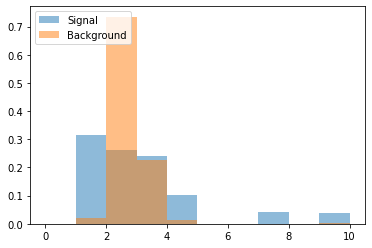

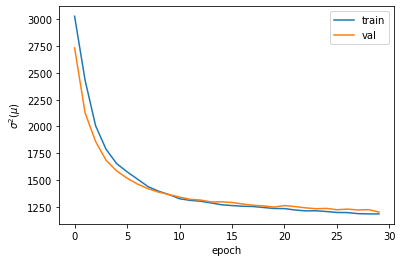


 	 ::: 6 SKOPT CALL ::: 

{'lr': 0.003829508693663697, 'temperature': 0.31271113846884824, 'neurons': 69}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.003829508693663697
n_feats 4
neurons 69
temperature 0.31271113846884824
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=2104.862041015625 Valid=1615.983154296875
2: Train=1459.3550341796874 Valid=1361.0229786839977
3: Train=1304.07419921875 Valid=1340.3767931707973
4: Train=1264.141416015625 Valid=1226.694163355334
5: Train=1167.1689184570312 Valid=1202.083424535291
6: Train=1148.6577758789062 Valid=1157.252001532193
7: Train=1118.8339892578124 Valid=1125.6541979559536
8: Train=1097.8052465820313 Valid=1105.812984071929
9: Train=1080.5738208007813 Valid=1085.1002975990032
10: Train=1065.6577319335938 Valid=1105.7946272225215
11: Train=1069.8455908203125 Valid=1086.1762421706628
12: Train=1061.97068359375 Valid=1109.5333820211476
13: Train=1058.3191284179688 Valid=1066.8585078798492
14: Train=1040.5700756835938 Valid=1087.8490474306304
15: Train=1031.82888671875 Valid=1093.4833584489493
16: Train=1055.0189135742187 Valid=1100.2616219356141
17: Train=1156.2619482421876 Valid=1184.4270903488684
18: Train=1099.2221069335938 Valid=1090.4885148673222
19: Train=1054.2569921875 Valid=1064.5388878131735

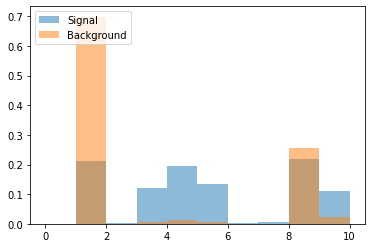

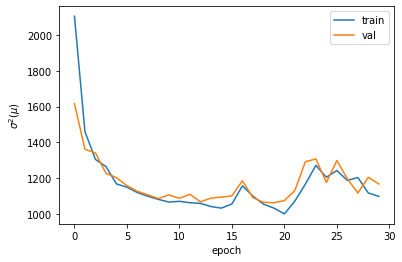


 	 ::: 7 SKOPT CALL ::: 

{'lr': 0.0070673841643105135, 'temperature': 0.6640147819491843, 'neurons': 62}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.0070673841643105135
n_feats 4
neurons 62
temperature 0.6640147819491843
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=2202.4106689453124 Valid=1544.8877500336746
2: Train=1399.332548828125 Valid=1356.5135140254579
3: Train=1272.4223754882812 Valid=1231.4420418574891
4: Train=1197.9169213867187 Valid=1177.2200464709051
5: Train=1135.8555981445313 Valid=1183.2200127963363
6: Train=1148.6510180664063 Valid=1157.8788662614493
7: Train=1106.358408203125 Valid=1124.2150121228449
8: Train=1070.459423828125 Valid=1102.5868403993804
9: Train=1056.5455908203126 Valid=1161.1887859476024
10: Train=1085.23857421875 Valid=1234.7244767813847
11: Train=1167.552890625 Valid=1314.5239131532867
12: Train=1233.7173315429689 Valid=1159.8138196221714
13: Train=1088.8440747070313 Valid=1122.295725855334
14: Train=1175.245244140625 Valid=1171.491593985722
15: Train=1137.9641479492188 Valid=1151.2124318089977
16: Train=1122.6024877929688 Valid=1084.0394855367726
17: Train=1069.0259350585939 Valid=1114.0738672716864
18: Train=1079.12701171875 Valid=1087.0454880286907
19: Train=1073.28189453125 Valid=1114.6095623147899

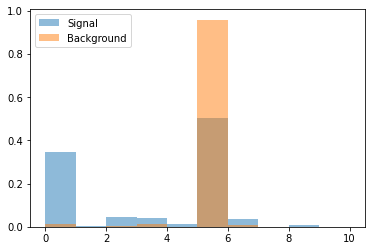

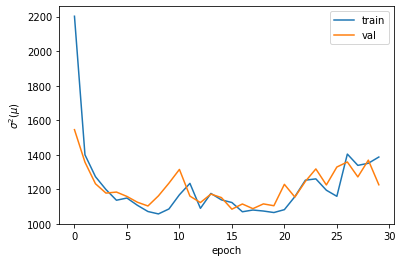


 	 ::: 8 SKOPT CALL ::: 

{'lr': 0.00012381214234993934, 'temperature': 0.08068733812752421, 'neurons': 180}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.00012381214234993934
n_feats 4
neurons 180
temperature 0.08068733812752421
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=2306.32712890625 Valid=1940.5239468278555
2: Train=1795.845234375 Valid=1714.2893487338363
3: Train=1623.4962158203125 Valid=1571.7335078798492
4: Train=1517.5768310546875 Valid=1465.5796277276402
5: Train=1447.1137451171876 Valid=1411.9822282462285
6: Train=1385.107177734375 Valid=1388.6167876144934
7: Train=1355.6222900390626 Valid=1359.771661166487
8: Train=1326.9970581054688 Valid=1325.4879192483836
9: Train=1300.62685546875 Valid=1310.5905972184805
10: Train=1285.5409326171875 Valid=1293.0952274717133
11: Train=1270.0919482421875 Valid=1274.0894649110992
12: Train=1248.15435546875 Valid=1262.1160109947468
13: Train=1243.7738208007813 Valid=1264.7929519127156
14: Train=1231.7484619140625 Valid=1244.5310332199622
15: Train=1206.916845703125 Valid=1241.4765077788254
16: Train=1200.6949780273437 Valid=1222.1852248619343
17: Train=1194.6478466796875 Valid=1219.9074054586476
18: Train=1186.709072265625 Valid=1211.231081206223
19: Train=1176.26369140625 Valid=1221.953718514278
2

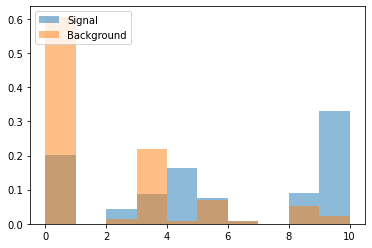

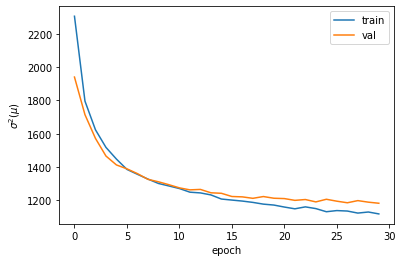


 	 ::: 9 SKOPT CALL ::: 

{'lr': 0.009673767405039039, 'temperature': 0.25282720016882304, 'neurons': 155}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.009673767405039039
n_feats 4
neurons 155
temperature 0.25282720016882304
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=1662.543818359375 Valid=1325.1024064688847
2: Train=1672.5492138671875 Valid=1644.8270895070043
3: Train=2427.9252099609375 Valid=2884.804923221983
4: Train=2951.201689453125 Valid=3172.7060715247844
5: Train=2782.1901318359373 Valid=3199.9666032462283
6: Train=2486.532412109375 Valid=3194.994982489224
7: Train=3200.000703125 Valid=3210.524515086207
8: Train=3199.81470703125 Valid=3199.7820076778016
9: Train=3200.004658203125 Valid=3200.753039129849
10: Train=3199.994892578125 Valid=3023.5584085398705
11: Train=3199.9816796875 Valid=3200.0238079202586
12: Train=3200.001259765625 Valid=3199.9812853582976
13: Train=3199.99640625 Valid=3199.9540426320045
14: Train=3199.995263671875 Valid=3199.9576458108836
15: Train=3199.762822265625 Valid=3200.0384563577586
16: Train=3200.04431640625 Valid=3199.730721309267
17: Train=3199.9958203125 Valid=3200.0069285425648
18: Train=3199.984794921875 Valid=3200.0052195581898
19: Train=3199.983828125 Valid=3200.0390372440734
20: Train=3200.00975

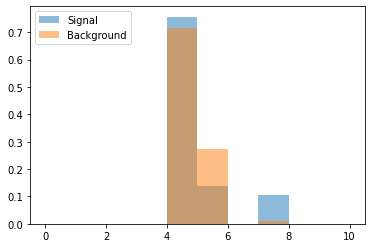

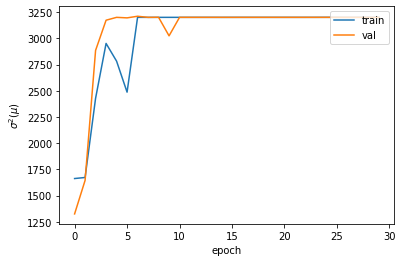


 	 ::: 10 SKOPT CALL ::: 

{'lr': 0.00243783716857707, 'temperature': 0.9192233151515897, 'neurons': 71}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.00243783716857707
n_feats 4
neurons 71
temperature 0.9192233151515897
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=2723.2662353515625 Valid=2006.4470762055496
2: Train=1762.75873046875 Valid=1582.3722891971984
3: Train=1547.9423193359376 Valid=1461.6513040476832
4: Train=1433.7709375 Valid=1373.3793145541488
5: Train=1354.4086328125 Valid=1313.9735023235453
6: Train=1307.8343701171875 Valid=1291.8567062904094
7: Train=1274.6006982421875 Valid=1282.7090117355872
8: Train=1245.4241137695312 Valid=1266.7367280105066
9: Train=1245.0909887695314 Valid=1250.4463479929957
10: Train=1216.0374560546875 Valid=1242.1877146753773
11: Train=1202.5267919921876 Valid=1214.3054367591594
12: Train=1189.338720703125 Valid=1200.5615529027477
13: Train=1174.2391748046875 Valid=1188.0007871430496
14: Train=1143.1746557617187 Valid=1161.246826171875
15: Train=1122.59787109375 Valid=1152.5940404431574
16: Train=1117.3757470703124 Valid=1137.0342196760507
17: Train=1103.7632153320312 Valid=1144.348077182112
18: Train=1098.167138671875 Valid=1132.6908863988415
19: Train=1094.4046020507812 Valid=1150.5636828192348


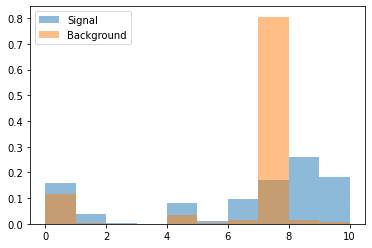

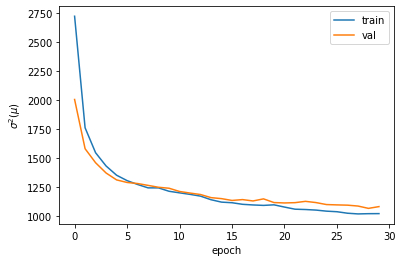


 	 ::: 11 SKOPT CALL ::: 

{'lr': 0.0018576527364465708, 'temperature': 0.14863050003558417, 'neurons': 192}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.0018576527364465708
n_feats 4
neurons 192
temperature 0.14863050003558417
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=1597.1483056640625 Valid=1384.6736302869074
2: Train=1343.7547802734375 Valid=1333.4998779296875
3: Train=1251.5701953125 Valid=1231.574850148168
4: Train=1208.5319604492188 Valid=1223.9476234172953
5: Train=1171.7467651367188 Valid=1168.967236749057
6: Train=1167.236875 Valid=1194.5384163692079
7: Train=1122.1204272460936 Valid=1200.7158792429957
8: Train=1141.5966967773438 Valid=1178.1651421908675
9: Train=1166.8812573242187 Valid=1191.481148555361
10: Train=1129.6883447265625 Valid=1154.2283830313847
11: Train=1109.2004028320312 Valid=1186.971239813443
12: Train=1126.478974609375 Valid=1134.423512425916
13: Train=1092.8359497070312 Valid=1115.914704421471
14: Train=1232.2890063476561 Valid=1265.8766205886316
15: Train=1260.8911669921874 Valid=1217.172171757139
16: Train=1448.113828125 Valid=1851.1487784550109
17: Train=1904.6249951171876 Valid=1560.428132155846
18: Train=1655.11287109375 Valid=1783.6465938173492
19: Train=2056.2825341796874 Valid=1776.6312150626347
20: Trai

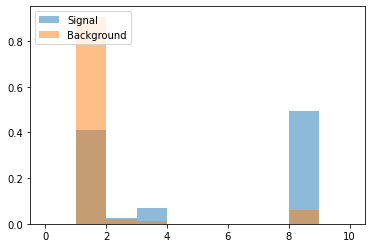

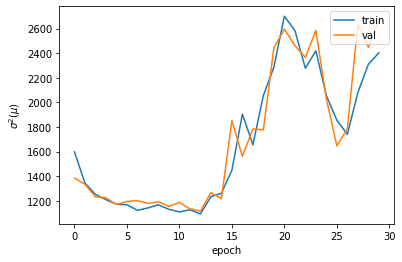


 	 ::: 12 SKOPT CALL ::: 

{'lr': 0.009043027002241254, 'temperature': 0.5637167893309362, 'neurons': 85}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.009043027002241254
n_feats 4
neurons 85
temperature 0.5637167893309362
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=1875.04953125 Valid=1418.1909432246766
2: Train=1373.4602124023438 Valid=1249.3821495319235
3: Train=1295.4618359375 Valid=1190.4223569672683
4: Train=1214.38521484375 Valid=1164.495853818696
5: Train=1266.6269018554688 Valid=1171.403440278152
6: Train=1235.2827270507812 Valid=1159.8547910492996
7: Train=1302.3137377929688 Valid=1399.140553441541
8: Train=1255.0616772460937 Valid=1194.9407053980335
9: Train=1267.0266528320312 Valid=1220.5088101091055
10: Train=1463.0980615234375 Valid=1736.2468851023707
11: Train=1867.9063134765624 Valid=2196.871375774515
12: Train=2301.7580322265626 Valid=2486.909625875539
13: Train=2717.095673828125 Valid=2830.062845164332
14: Train=2712.90361328125 Valid=2725.532967403017
15: Train=2360.7293798828123 Valid=2023.9746304216055
16: Train=1739.0540283203125 Valid=1586.539938038793
17: Train=1950.6758740234375 Valid=2312.097454202586
18: Train=1909.8155224609375 Valid=1833.8010759024785
19: Train=2354.31830078125 Valid=2482.8349441002156
20: Tra

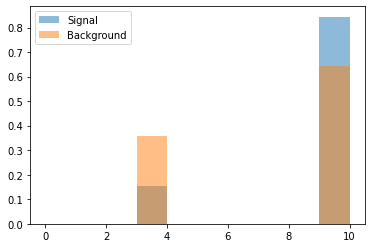

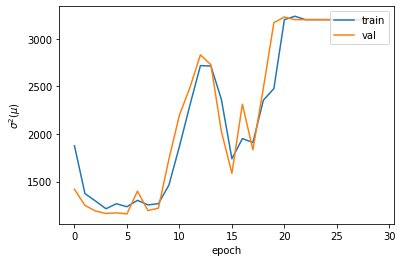


 	 ::: 13 SKOPT CALL ::: 

{'lr': 0.009645873845161856, 'temperature': 0.14074063429598838, 'neurons': 135}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.009645873845161856
n_feats 4
neurons 135
temperature 0.14074063429598838
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=1701.236630859375 Valid=1365.2013023639547
2: Train=2452.0472607421875 Valid=3189.423760775862
3: Train=2985.1305517578126 Valid=3200.010599070582
4: Train=3200.015546875 Valid=3201.370403421336
5: Train=3171.04447265625 Valid=3200.0068359375
6: Train=3200.188515625 Valid=3200.0248770878234
7: Train=3200.019794921875 Valid=3200.4483347925648
8: Train=3199.95626953125 Valid=3199.9795090247844
9: Train=3200.023779296875 Valid=3204.659600619612
10: Train=3200.011279296875 Valid=3198.8089136584053
11: Train=3199.841513671875 Valid=3205.143032731681
12: Train=3200.006982421875 Valid=3199.9970703125
13: Train=3200.01640625 Valid=3200.087991648707
14: Train=3192.200537109375 Valid=3009.234427616514

 	 ::: 14 SKOPT CALL ::: 

{'lr': 0.00023471406017940377, 'temperature': 0.9581634896492418, 'neurons': 147}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weig

1: Train=3163.3863671875 Valid=3099.6295629040947
2: Train=2992.27087890625 Valid=2815.515869140625
3: Train=2640.678134765625 Valid=2440.3710095635774
4: Train=2295.7507666015626 Valid=2119.877504546067
5: Train=2064.59017578125 Valid=1943.9880497373383
6: Train=1899.0507177734376 Valid=1808.0414870689656
7: Train=1784.4869873046875 Valid=1717.8711905643859
8: Train=1694.14365234375 Valid=1645.8175048828125
9: Train=1641.4158203125 Valid=1607.8428702518859
10: Train=1590.2349462890625 Valid=1557.6520448882004
11: Train=1553.7036865234375 Valid=1526.427805933459
12: Train=1518.4630517578125 Valid=1503.356790476832
13: Train=1479.1570654296875 Valid=1470.9119115369074
14: Train=1452.0825830078124 Valid=1442.6974339978449
15: Train=1427.5254150390624 Valid=1421.517826474946
16: Train=1407.9695849609375 Valid=1411.4904280037715
17: Train=1386.79181640625 Valid=1394.9390995420258
18: Train=1369.3540478515624 Valid=1375.1368534482758
19: Train=1356.722353515625 Valid=1374.9515717605066
20: 

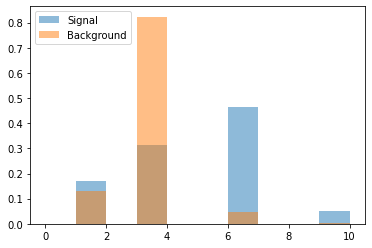

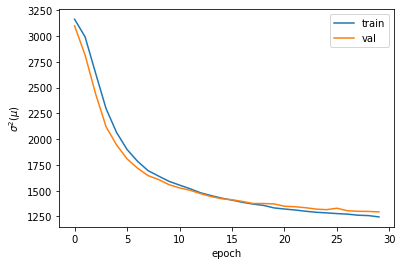


 	 ::: 15 SKOPT CALL ::: 

{'lr': 0.0001, 'temperature': 0.0625759037043653, 'neurons': 163}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.0001
n_feats 4
neurons 163
temperature 0.0625759037043653
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=2488.91310546875 Valid=1957.421559300916
2: Train=1812.31275390625 Valid=1600.9693519329203
3: Train=1556.567158203125 Valid=1442.5723119275324
4: Train=1443.688076171875 Valid=1368.7876060748922
5: Train=1384.638857421875 Valid=1331.722134294181
6: Train=1353.9995190429688 Valid=1306.4479812095906
7: Train=1308.7103295898437 Valid=1274.484791722791
8: Train=1288.889462890625 Valid=1267.884487809806
9: Train=1269.8550317382812 Valid=1255.538727858971
10: Train=1255.956796875 Valid=1237.189764614763
11: Train=1246.34228515625 Valid=1224.9701517039332
12: Train=1228.4153271484374 Valid=1228.2466809502964
13: Train=1226.106767578125 Valid=1220.1727568527747
14: Train=1207.5158959960938 Valid=1217.1012425915949
15: Train=1191.365732421875 Valid=1204.0438295561692
16: Train=1184.4075512695313 Valid=1208.475030307112
17: Train=1192.9371264648437 Valid=1190.8347715180496
18: Train=1179.0287182617187 Valid=1197.3552119814117
19: Train=1179.1529052734375 Valid=1195.5233785695043
20: Tr

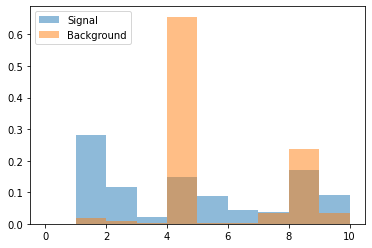

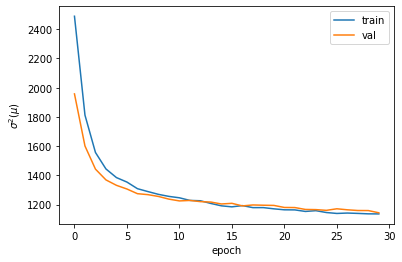


 	 ::: 16 SKOPT CALL ::: 

{'lr': 0.0001, 'temperature': 0.06882821856928761, 'neurons': 53}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.0001
n_feats 4
neurons 53
temperature 0.06882821856928761
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=3101.086181640625 Valid=2964.4324235587283
2: Train=2772.12314453125 Valid=2516.1356243265086
3: Train=2316.824169921875 Valid=2134.4000875538795
4: Train=2033.8831103515624 Valid=1929.6431295460668
5: Train=1896.8324072265625 Valid=1816.4604239628234
6: Train=1800.772138671875 Valid=1743.5419500942887
7: Train=1734.02853515625 Valid=1694.5806421740301
8: Train=1680.0281494140625 Valid=1641.8563527074352
9: Train=1633.4660107421876 Valid=1592.7621565193965
10: Train=1599.474130859375 Valid=1554.4940648572199
11: Train=1571.456591796875 Valid=1531.2208546605602
12: Train=1532.4073046875 Valid=1506.8139522157867
13: Train=1510.954296875 Valid=1476.5311026737609
14: Train=1488.804296875 Valid=1464.936350855334
15: Train=1468.9456884765625 Valid=1439.534634294181
16: Train=1455.905263671875 Valid=1432.6025222252156
17: Train=1435.851953125 Valid=1418.6548440867457
18: Train=1424.81888671875 Valid=1397.147953428071
19: Train=1408.456728515625 Valid=1385.6469221443965
20: Train=1396

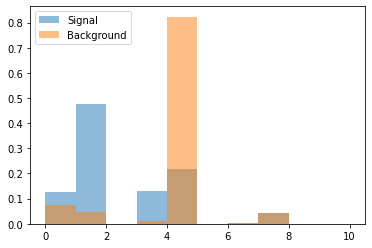

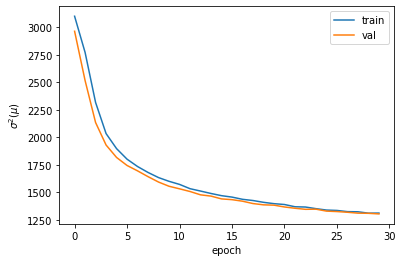


 	 ::: 17 SKOPT CALL ::: 

{'lr': 0.01, 'temperature': 0.8549074841484525, 'neurons': 186}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.01
n_feats 4
neurons 186
temperature 0.8549074841484525
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=1796.0378369140626 Valid=1381.5908097891972
2: Train=1264.450361328125 Valid=1200.816071608971
3: Train=1216.6268310546875 Valid=1241.0556009226832
4: Train=1296.5580322265625 Valid=1317.1774039432921
5: Train=1266.034638671875 Valid=1351.8259256297144
6: Train=1451.9025341796876 Valid=1850.3176059065195

 	 ::: 18 SKOPT CALL ::: 

{'lr': 0.0023900694555425163, 'temperature': 0.7529023501583789, 'neurons': 153}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.0023900694555425163
n_feats 4
neurons 153
temperature 0.7529023501583789
bin

1: Train=2198.11361328125 Valid=1564.864114695582
2: Train=1436.572587890625 Valid=1374.4065783270473
3: Train=1317.2903686523437 Valid=1327.5373156317348
4: Train=1238.864345703125 Valid=1243.308109678071
5: Train=1173.2898217773438 Valid=1187.4890978582973
6: Train=1126.8720458984376 Valid=1169.2566907159214
7: Train=1117.3855322265624 Valid=1153.0391277444774
8: Train=1092.5795288085938 Valid=1136.285640321929
9: Train=1077.610849609375 Valid=1135.8870323444235
10: Train=1079.3358642578125 Valid=1138.5155323949352
11: Train=1070.2681420898436 Valid=1117.2466241244613
12: Train=1048.676708984375 Valid=1113.6956829202586
13: Train=1048.076044921875 Valid=1117.709003316945
14: Train=1075.3670166015625 Valid=1145.3682335162985
15: Train=1227.7013745117188 Valid=1204.2044530408136
16: Train=1089.3691333007812 Valid=1107.215212065598
17: Train=1078.68271484375 Valid=1132.3106836779364
18: Train=1085.4505688476563 Valid=1087.5632766197468
19: Train=1049.1311962890625 Valid=1105.18786831559

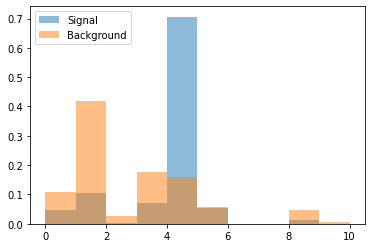

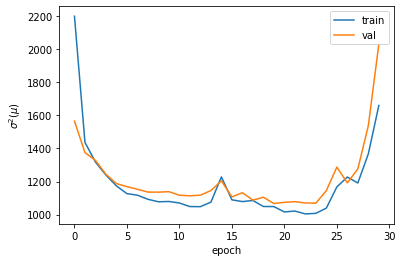


 	 ::: 19 SKOPT CALL ::: 

{'lr': 0.001070694594892739, 'temperature': 0.9436479482919313, 'neurons': 82}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.001070694594892739
n_feats 4
neurons 82
temperature 0.9436479482919313
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=3043.66248046875 Valid=2719.662740773168
2: Train=2322.081787109375 Valid=1963.2893992456898
3: Train=1865.4485546875 Valid=1727.920405946929
4: Train=1708.601748046875 Valid=1606.1866791823816
5: Train=1623.8814794921875 Valid=1529.5099213698816
6: Train=1533.66509765625 Valid=1469.2690345501078
7: Train=1471.490380859375 Valid=1414.3826567551184
8: Train=1418.0031005859375 Valid=1375.09788144868
9: Train=1369.807587890625 Valid=1358.7115773168102
10: Train=1333.2837744140625 Valid=1320.4856462149785
11: Train=1300.9435107421875 Valid=1293.840159449084
12: Train=1287.81330078125 Valid=1280.7809911267511
13: Train=1267.8387890625 Valid=1268.3059439823546
14: Train=1250.252587890625 Valid=1260.4378746295797
15: Train=1232.1622924804688 Valid=1247.4747714338632
16: Train=1220.4912084960938 Valid=1238.9988298087285
17: Train=1213.7077294921876 Valid=1226.8235789331898
18: Train=1200.7953100585937 Valid=1219.296875
19: Train=1195.4244702148437 Valid=1216.336760422279
20: Train=117

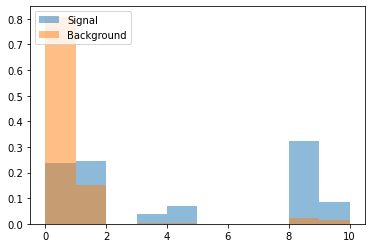

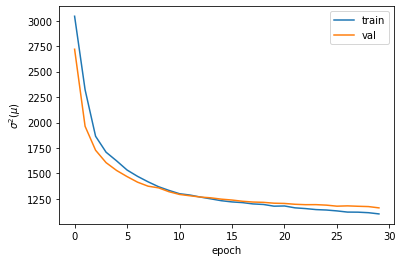


 	 ::: 20 SKOPT CALL ::: 

{'lr': 0.000616355411024755, 'temperature': 0.050053735312842934, 'neurons': 194}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.000616355411024755
n_feats 4
neurons 194
temperature 0.050053735312842934
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=1615.4639306640624 Valid=1374.9906637257543
2: Train=1286.265029296875 Valid=1314.4612279431574
3: Train=1242.1821826171874 Valid=1261.753954657193
4: Train=1189.427724609375 Valid=1199.1764379040949
5: Train=1175.657236328125 Valid=1210.201517039332
6: Train=1148.8880932617187 Valid=1211.8853465113148
7: Train=1149.3355053710939 Valid=1202.8813687028555
8: Train=1144.25056640625 Valid=1164.497291301859
9: Train=1147.3171264648438 Valid=1122.7813846982758
10: Train=1106.801357421875 Valid=1153.4719701306574
11: Train=1104.3254736328124 Valid=1138.8642451845367
12: Train=1120.8394091796874 Valid=1120.678729879445
13: Train=1089.6158837890625 Valid=1139.1524552970097
14: Train=1095.4913208007813 Valid=1097.8970884125808
15: Train=1044.5951489257814 Valid=1071.5529153758082
16: Train=1070.2027270507813 Valid=1097.3786158068426
17: Train=1073.9175708007813 Valid=1109.8601389917835
18: Train=1107.7923461914063 Valid=1117.2631541285023
19: Train=1071.8487768554687 Valid=1104.2845690

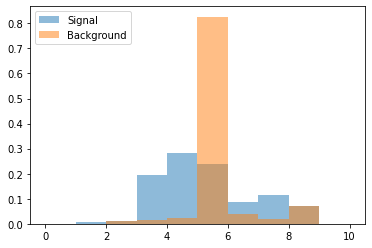

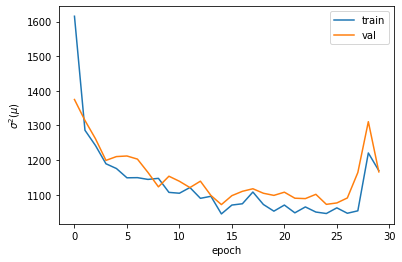


 	 ::: 21 SKOPT CALL ::: 

{'lr': 0.0001, 'temperature': 0.3107575412160147, 'neurons': 199}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.0001
n_feats 4
neurons 199
temperature 0.3107575412160147
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=3016.5728515625 Valid=2777.7384748787717
2: Train=2466.9058203125 Valid=2260.798230401401
3: Train=2079.4622265625 Valid=2010.0317088160023
4: Train=1907.7236962890624 Valid=1865.8261171538254
5: Train=1787.7303271484375 Valid=1759.0269143992457
6: Train=1709.53927734375 Valid=1701.7484551791488
7: Train=1641.583046875 Valid=1650.1890448208512
8: Train=1584.19931640625 Valid=1603.252757105334
9: Train=1545.563603515625 Valid=1556.7573663119613
10: Train=1513.593681640625 Valid=1530.5030938510238
11: Train=1501.2654248046874 Valid=1529.7460727033945
12: Train=1462.413720703125 Valid=1508.7756263469828
13: Train=1444.2435546875 Valid=1491.6415510506465
14: Train=1418.143203125 Valid=1455.1383477572738
15: Train=1408.8476318359376 Valid=1450.1446785762391
16: Train=1401.83439453125 Valid=1429.8390608162715
17: Train=1398.493173828125 Valid=1422.6539011988148
18: Train=1381.836728515625 Valid=1447.897953428071
19: Train=1370.1619775390625 Valid=1412.9371043238148
20: Train=1347.17

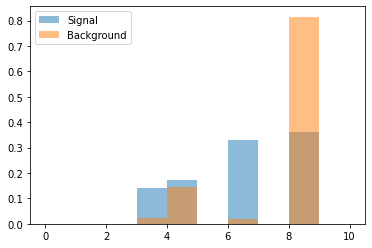

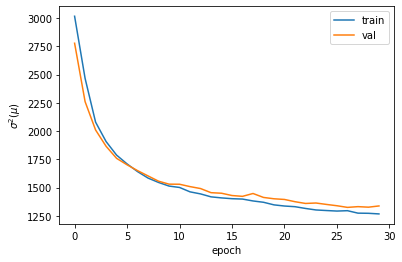


 	 ::: 22 SKOPT CALL ::: 

{'lr': 0.0006773312292242044, 'temperature': 0.0536067467577516, 'neurons': 55}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.0006773312292242044
n_feats 4
neurons 55
temperature 0.0536067467577516
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=2271.2220068359375 Valid=1672.6985999797953
2: Train=1558.66265625 Valid=1429.9910551926184
3: Train=1393.0038818359376 Valid=1332.1318948679957
4: Train=1305.0169262695313 Valid=1296.8029343177532
5: Train=1258.8228173828124 Valid=1272.1147629310344
6: Train=1230.886640625 Valid=1259.0653707570043
7: Train=1213.0441577148438 Valid=1229.1991408775593
8: Train=1199.6400463867187 Valid=1220.1644013503503
9: Train=1185.9467260742188 Valid=1226.199342924973
10: Train=1168.0070581054688 Valid=1218.357767039332
11: Train=1158.067587890625 Valid=1187.2196044921875
12: Train=1151.8529833984376 Valid=1198.4185875202047
13: Train=1138.5588208007812 Valid=1199.0880063813308
14: Train=1140.2171459960937 Valid=1198.4861829034214
15: Train=1139.23412109375 Valid=1187.0972311085668
16: Train=1124.2748828125 Valid=1198.8061818089977
17: Train=1140.9516577148438 Valid=1202.7862275222253
18: Train=1115.9727197265624 Valid=1184.230746565194
19: Train=1122.6056372070314 Valid=1182.6225186051993
2

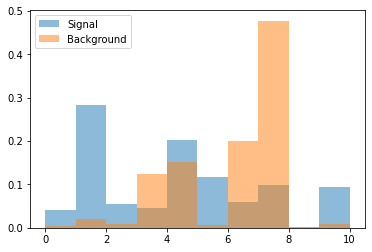

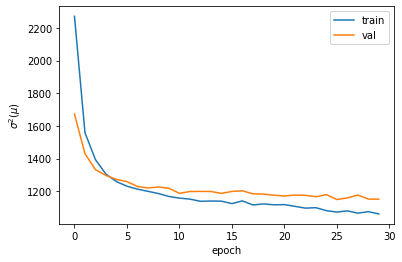


 	 ::: 23 SKOPT CALL ::: 

{'lr': 0.00018257024606840758, 'temperature': 0.01, 'neurons': 200}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.00018257024606840758
n_feats 4
neurons 200
temperature 0.01
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=1802.7754736328125 Valid=1517.5024245689656
2: Train=1443.451630859375 Valid=1405.1756654936692
3: Train=1385.6644189453125 Valid=1405.166436557112
4: Train=1371.0218725585937 Valid=1361.7563560748922
5: Train=1268.1851928710937 Valid=1342.528669686153
6: Train=1196.8458642578125 Valid=1340.8114055765086
7: Train=1227.8356762695312 Valid=1331.922975737473
8: Train=1253.1293408203126 Valid=1384.2484467605066
9: Train=1249.52525390625 Valid=1466.4642965382543
10: Train=1358.6005493164062 Valid=1486.930563038793
11: Train=1288.9475634765624 Valid=1417.9477076037176
12: Train=1318.50408203125 Valid=1413.0254074622844
13: Train=1255.40416015625 Valid=1425.6326904296875
14: Train=1241.7071118164063 Valid=1345.8826251852101
15: Train=1248.916572265625 Valid=1515.7342908135777
16: Train=1304.265419921875 Valid=1364.9228242019128
17: Train=1278.1790576171875 Valid=1359.8191380994074
18: Train=1409.039638671875 Valid=1487.5437895676184
19: Train=1455.584658203125 Valid=1510.289733886718

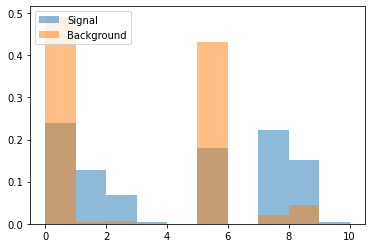

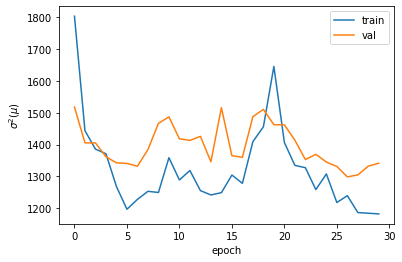


 	 ::: 24 SKOPT CALL ::: 

{'lr': 0.0006035880106703501, 'temperature': 0.13247246418750178, 'neurons': 200}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.0006035880106703501
n_feats 4
neurons 200
temperature 0.13247246418750178
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=1921.20396484375 Valid=1568.411027579472
2: Train=1465.0228369140625 Valid=1457.1436767578125
3: Train=1354.508623046875 Valid=1353.4684427195582
4: Train=1272.4915478515625 Valid=1292.2046740301723
5: Train=1231.8652392578124 Valid=1265.991593985722
6: Train=1187.3641650390625 Valid=1266.038822568696
7: Train=1172.3070825195311 Valid=1220.0645394160829
8: Train=1151.7764892578125 Valid=1194.1905959556843
9: Train=1139.5175 Valid=1199.7077552532328
10: Train=1118.7793579101562 Valid=1174.1839852168641
11: Train=1118.0232958984375 Valid=1172.8273567988954
12: Train=1092.4035888671874 Valid=1171.551997743804
13: Train=1093.8903857421874 Valid=1158.185445851293
14: Train=1050.3064111328124 Valid=1143.8581164129848
15: Train=1065.9386596679688 Valid=1166.4463037951239
16: Train=1046.8986840820312 Valid=1124.49245058257
17: Train=1040.6965576171874 Valid=1144.4816831391433
18: Train=1057.0403540039063 Valid=1135.7955659011316
19: Train=1044.6366650390626 Valid=1126.0868256667566
20

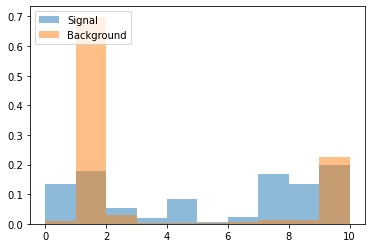

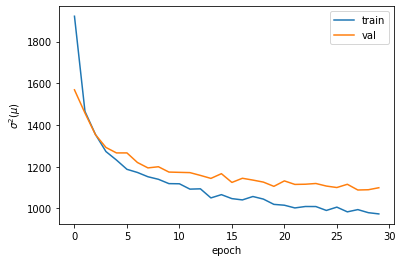


 	 ::: 25 SKOPT CALL ::: 

{'lr': 0.01, 'temperature': 0.32013452876124754, 'neurons': 196}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.01
n_feats 4
neurons 196
temperature 0.32013452876124754
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=1821.439501953125 Valid=1422.4576794854527
2: Train=1489.7497900390624 Valid=1449.9304093985722
3: Train=2072.1518896484376 Valid=1892.7942147090516
4: Train=2159.2632080078124 Valid=2181.125454606681
5: Train=2946.302802734375 Valid=3198.8023723733836
6: Train=3200.060439453125 Valid=3200.0542160560344
7: Train=3200.041591796875 Valid=3199.9249983162717
8: Train=3200.065078125 Valid=3199.928020608836
9: Train=3200.053759765625 Valid=3199.9533438846984
10: Train=3200.092470703125 Valid=3199.9796773976295
11: Train=3199.901787109375 Valid=3200.0147999730602
12: Train=3200.003828125 Valid=3199.986858499461
13: Train=3199.644765625 Valid=3199.992566338901
14: Train=3200.0030078125 Valid=3199.9548171470906
15: Train=3200.10296875 Valid=3199.964953192349
16: Train=3200.006337890625 Valid=3199.9971460802803
17: Train=3199.976923828125 Valid=3200.009479391164
18: Train=3199.97033203125 Valid=3201.5312668372844
19: Train=3199.994287109375 Valid=3200.1330818965516
20: Train=3200.006845

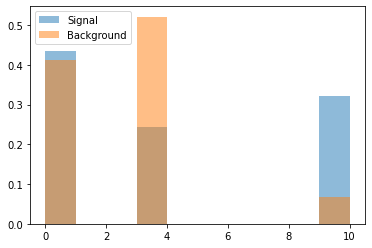

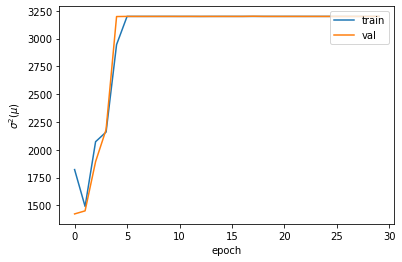


 	 ::: 26 SKOPT CALL ::: 

{'lr': 0.0001579828436945954, 'temperature': 0.09385041316040842, 'neurons': 93}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.0001579828436945954
n_feats 4
neurons 93
temperature 0.09385041316040842
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=2651.02330078125 Valid=2254.2888730805494
2: Train=2040.59921875 Valid=1931.4316827182113
3: Train=1849.64841796875 Valid=1803.0433433795797
4: Train=1761.33353515625 Valid=1740.5742650525324
5: Train=1701.667236328125 Valid=1675.2647326239223
6: Train=1652.263515625 Valid=1625.0282403353988
7: Train=1604.0859423828124 Valid=1589.889437971444
8: Train=1553.1947705078126 Valid=1547.347412109375
9: Train=1521.552294921875 Valid=1506.343400626347
10: Train=1484.503984375 Valid=1471.7892561287715
11: Train=1447.9527197265625 Valid=1440.8567988954742
12: Train=1417.6044287109376 Valid=1418.6238761112609
13: Train=1390.3000390625 Valid=1394.823069605334
14: Train=1372.805400390625 Valid=1372.5887072332973
15: Train=1355.87013671875 Valid=1349.3021703259699
16: Train=1335.4076513671876 Valid=1336.8219751818426
17: Train=1324.5303564453125 Valid=1317.328019766972
18: Train=1306.523876953125 Valid=1311.0371683054957
19: Train=1294.9479638671876 Valid=1300.240688981681
20: Train=1283.88

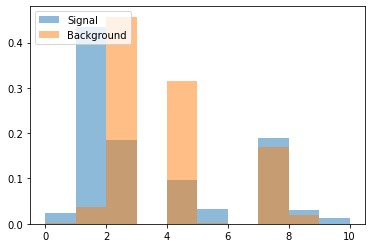

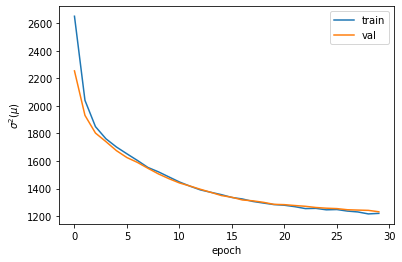


 	 ::: 27 SKOPT CALL ::: 

{'lr': 0.0016337511066641301, 'temperature': 0.7007041623123308, 'neurons': 56}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.0016337511066641301
n_feats 4
neurons 56
temperature 0.7007041623123308
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=2987.819775390625 Valid=2575.7873282596984
2: Train=2117.4557666015626 Valid=1769.3094524515086
3: Train=1659.800537109375 Valid=1593.421702417834
4: Train=1543.770888671875 Valid=1501.7538094356141
5: Train=1472.998798828125 Valid=1446.2728018925109
6: Train=1443.2730078125 Valid=1402.3113929485453
7: Train=1371.0038061523437 Valid=1358.6998038456359
8: Train=1347.1277197265624 Valid=1320.9599230536098
9: Train=1317.1035693359374 Valid=1301.1402166958512
10: Train=1287.6665380859374 Valid=1291.941827182112
11: Train=1278.547333984375 Valid=1271.3862704573007
12: Train=1269.4823876953126 Valid=1256.2367280105066
13: Train=1262.3900415039063 Valid=1259.9226389917835
14: Train=1250.4054614257811 Valid=1249.8346010405442
15: Train=1235.6679321289062 Valid=1234.650946255388
16: Train=1228.394052734375 Valid=1227.4623202619882
17: Train=1222.612177734375 Valid=1219.4243816507274
18: Train=1214.7528759765626 Valid=1208.3520865604796
19: Train=1199.00732421875 Valid=1197.840622474407

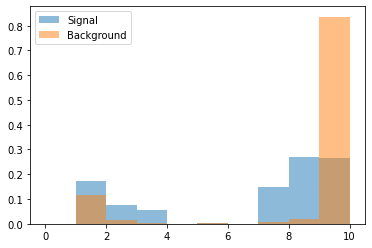

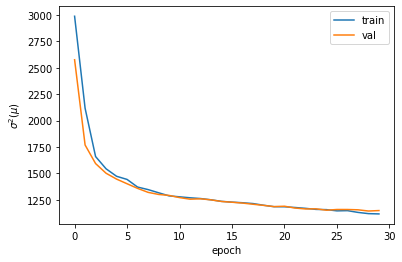


 	 ::: 28 SKOPT CALL ::: 

{'lr': 0.0032687746614495695, 'temperature': 0.35816237654178545, 'neurons': 101}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.0032687746614495695
n_feats 4
neurons 101
temperature 0.35816237654178545
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=2032.9050244140626 Valid=1509.273576407597
2: Train=1365.146279296875 Valid=1340.7470787311422
3: Train=1246.530361328125 Valid=1271.6917429956898
4: Train=1184.55349609375 Valid=1220.2761925006735
5: Train=1142.2379443359375 Valid=1211.375311489763
6: Train=1125.1285815429687 Valid=1143.0783965012122
7: Train=1092.3207006835937 Valid=1179.5738967369343
8: Train=1066.51298828125 Valid=1165.17333984375
9: Train=1071.3417163085937 Valid=1132.1429380219558
10: Train=1051.0346752929688 Valid=1158.1481323242188
11: Train=1057.0970776367187 Valid=1127.1578011348329
12: Train=1048.9972802734376 Valid=1141.817694302263
13: Train=1065.7030004882813 Valid=1157.5959199050378
14: Train=1041.9644213867186 Valid=1104.528177195582
15: Train=1050.70755859375 Valid=1151.0570489291488
16: Train=1061.1929858398437 Valid=1131.893171639278
17: Train=1075.8241015625 Valid=1112.4092975484914
18: Train=1049.6805639648437 Valid=1160.2182490907867
19: Train=1096.8746923828126 Valid=1103.0585621800915
2

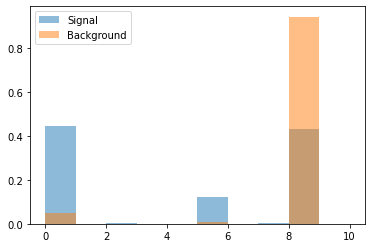

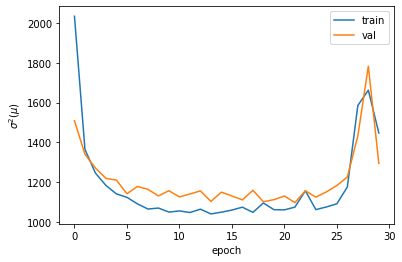


 	 ::: 29 SKOPT CALL ::: 

{'lr': 0.0002523030233946563, 'temperature': 0.24907236349648224, 'neurons': 108}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.0002523030233946563
n_feats 4
neurons 108
temperature 0.24907236349648224
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=2963.789794921875 Valid=2646.372794315733
2: Train=2345.1887353515626 Valid=2064.4554022427264
3: Train=1920.2142333984375 Valid=1829.851179451778
4: Train=1730.2561279296874 Valid=1691.2359282394934
5: Train=1602.653505859375 Valid=1594.8881288725754
6: Train=1528.2799462890625 Valid=1536.0774220433727
7: Train=1481.7394775390626 Valid=1496.6847218480602
8: Train=1443.9461669921875 Valid=1457.843021787446
9: Train=1416.404921875 Valid=1432.2569537984914
10: Train=1397.55349609375 Valid=1410.915316877694
11: Train=1376.9522802734375 Valid=1387.0298314587824
12: Train=1359.8155712890625 Valid=1369.4408800848598
13: Train=1347.9256982421875 Valid=1353.7495538119613
14: Train=1328.2516162109375 Valid=1344.0457048087285
15: Train=1318.5722607421876 Valid=1321.1063632307382
16: Train=1315.1237939453124 Valid=1324.6740806842672
17: Train=1293.0713818359375 Valid=1299.5303029027477
18: Train=1282.2715942382813 Valid=1287.5732674434266
19: Train=1278.2400439453124 Valid=1276.880834119

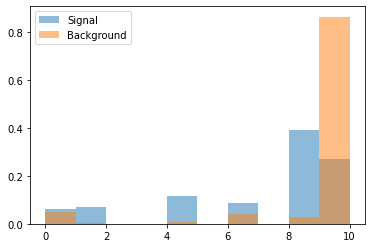

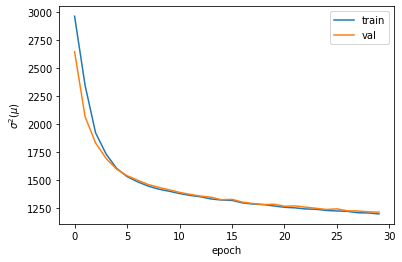


 	 ::: 30 SKOPT CALL ::: 

{'lr': 0.0005658786287281878, 'temperature': 0.45104547065588496, 'neurons': 200}
*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary dataloader
batch size 1000
epochs 30
x torch.Size([4, 5])
y tensor([1.])
w None
*********************
*********************
Summary NN setup
learning rate 0.0005658786287281878
n_feats 4
neurons 200
temperature 0.45104547065588496
bins 10
weights False
*********************
*********************
Summary INFERNO setup
b_true 2800
mu_true 400
nshape_alphas 2
shape_aux None
s_norm_aux []
n_alpha 3
*********************


1: Train=2515.3369384765624 Valid=1829.076449690194
2: Train=1736.800908203125 Valid=1607.1103052599676
3: Train=1576.848896484375 Valid=1501.184881802263
4: Train=1456.8484912109375 Valid=1429.4017733869882
5: Train=1370.9222998046876 Valid=1342.3184856546336
6: Train=1313.3293310546876 Valid=1319.1944832637391
7: Train=1284.745 Valid=1293.1270836139547
8: Train=1259.6137524414062 Valid=1268.398020777209
9: Train=1242.9569775390626 Valid=1254.367766281654
10: Train=1216.6696240234376 Valid=1233.8917720400054
11: Train=1215.0487890625 Valid=1222.492431640625
12: Train=1199.1947631835938 Valid=1219.6158910290949
13: Train=1187.4298608398437 Valid=1208.0675974878773
14: Train=1173.8222143554688 Valid=1199.1864645070043
15: Train=1170.9803100585937 Valid=1196.8370319234914
16: Train=1162.6342993164062 Valid=1181.4652899380387
17: Train=1166.2745776367187 Valid=1191.7487814015356
18: Train=1151.0697241210937 Valid=1156.1224260001347
19: Train=1138.1348779296875 Valid=1151.9375736631196
20:

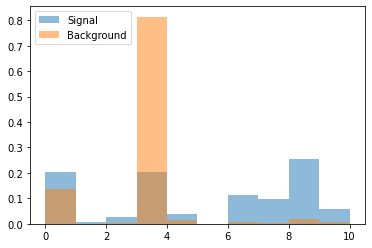

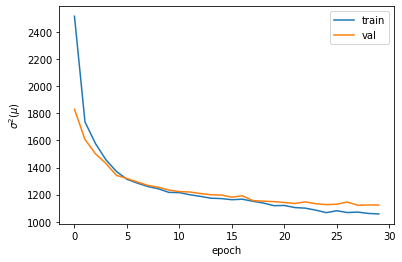

In [19]:
search_result, prior_names = find_optimal_parameters( skopt_dim_nominal, initial_param, num_calls=30)

In [20]:
store_results(search_result, prior_names)

,call,lr,temperature,neurons,score
5,5,0.003830,0.312711,69,1061.558310
17,17,0.002390,0.752902,153,1067.052755
9,9,0.002438,0.919223,71,1068.814276
19,19,0.000616,0.050054,194,1071.552915
3,3,0.002904,0.636750,143,1080.803418
6,6,0.007067,0.664015,62,1084.039486
23,23,0.000604,0.132472,200,1088.203634
1,1,0.001305,0.762291,142,1093.286686
0,0,0.001000,0.200000,80,1093.494286
27,27,0.003269,0.358162,101,1098.499053


In [21]:
search_result

          fun: 1061.5583096208243
    func_vals: array([ 1093.49428585,  1093.28668634,  1278.3741876 ,  1080.80341839,
        1199.86362431,  1061.55830962,  1084.03948554,  1181.58636054,
        1325.10240647,  1068.81427633,  1115.91470442,  1159.85479105,
       10000.        ,  1293.55340155,  1143.72135347,  1302.99318932,
       10000.        ,  1067.05275542,  1162.03028396,  1071.55291538,
        1324.93326121,  1149.36091351,  1298.42326829,  1088.20363433,
        1422.45767949,  1231.59467184,  1144.19765288,  1098.4990529 ,
        1210.41875589,  1121.78416285])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=940390913), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2